# Traffic Sign Classification

Let's build and train a deep neural network to classify traffic signs, using TensorFlow. Let's performed image pre-processing and validation to guard against overfitting.

Check the [write up template](https://github.com/rzuccolo/rz-carnd-traffic-sign/blob/master/writeup_traffic-sign.md) before navigate the code to get good insights about this project and get mportant reference such as dataset download.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = './traffic-signs-data/train.p'
validation_file= './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Basic Summary of the Data Set

In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Visualizing the German Traffic Signs Dataset using the pickled file(s). Plotting traffic sign images, plotting the count of each sign, etc.


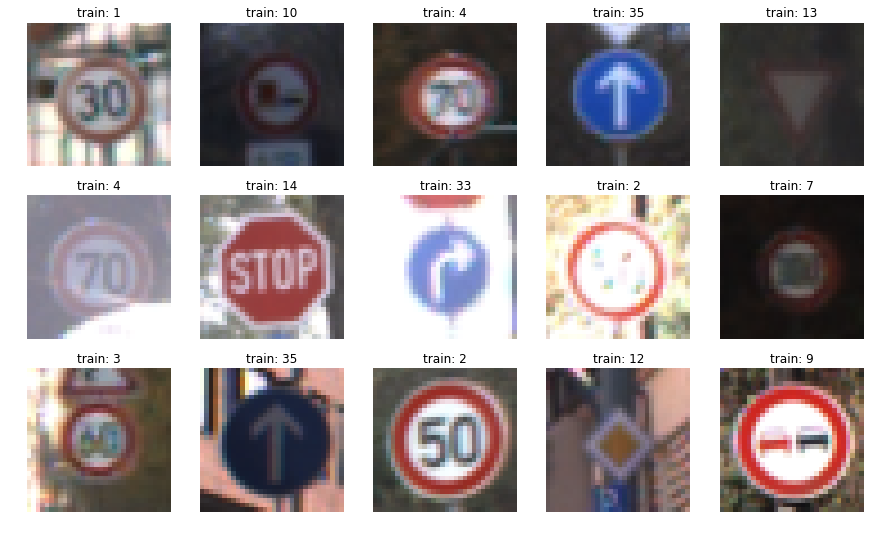

In [3]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

#  Plotting traffic sign images
def plotsignal(images, labels, nrows=1, ncols=1, cmap=None, prefix_label = 'label:'):
    """
    Plot images in a subplot arrangement.
    images = 4D array containing raw pixel data of the images, (num examples, width, height, channels)
    labels = 1D array containing the label/class id of the image
    nrows = numbers of rows in the image plot arrangement
    ncols = numbers of columns in the image plot arrangement
    prefix_label = prefix label to show on top of images
    """
    scalesize = 3*nrows*ncols
    f, axarr = plt.subplots(nrows, ncols, figsize=(scalesize/nrows, scalesize/ncols))
    if (nrows != 1) and (ncols != 1): # Take care of error in case nrows/ncols = 1
        axarr = axarr.ravel()
    if (nrows == 1) and (ncols == 1): # Take care of error in case both nrows/ncols = 1
        index = np.random.randint(0, len(images))
        image = images[index].squeeze()
        axarr.axis('off')
        axarr.imshow(image, cmap=cmap)
        axarr.set_title(prefix_label + ' ' + labels[index])
    else:
        for i in range(nrows*ncols):
            index = np.random.randint(0, len(images))
            image = images[index].squeeze()
            axarr[i].axis('off')
            axarr[i].imshow(image, cmap=cmap)
            axarr[i].set_title(prefix_label + ' ' + str(labels[index]))

nrows = 3 # change it here the way you want, 0 will give error
ncols = 5 # change it here the way you want, 0 will give error
plotsignal(X_train, y_train, nrows, ncols, cmap=None, prefix_label = 'train:')

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


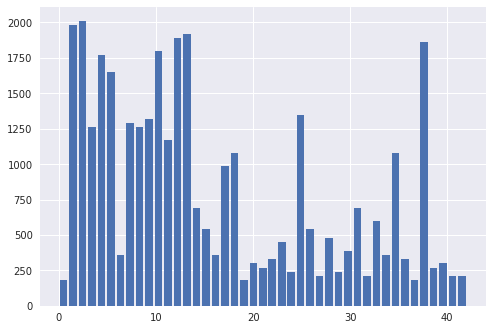

In [4]:
# Enlarge Inline Pictures
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = "14, 8" # or  whatever you want

# Plotting the count of each sign
import seaborn as sns
n, bins, patches = plt.hist(y_train, bins=n_classes, rwidth=0.8)

----

## Step 2: Desig and Test Model Architecture

Designing and implementing a deep learning model that learns to recognize traffic signs. Trainning and testing the model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider here:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.


### Pre-process the Data Set (jittering, normalization, etc.)

In [5]:
# That is helper function to jitter the data. Reference below:
# https://chatbotslife.com/german-sign-classification-using-deep-learning-neural-networks-98-8-solution-d05656bf51ad#.2fky8ow3g
# https://medium.com/@vivek.yadav/dealing-with-unbalanced-data-generating-additional-data-by-jittering-the-original-image-7497fe2119c3#.t2tjvnix2
# https://github.com/vxy10/ImageAugmentation

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2

import numpy as np
%matplotlib inline
import matplotlib.image as mpimg

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness


    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
      img = augment_brightness_camera_images(img)

    return img

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


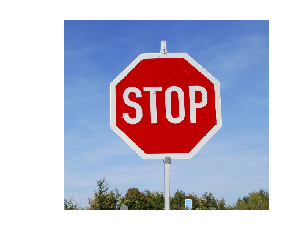

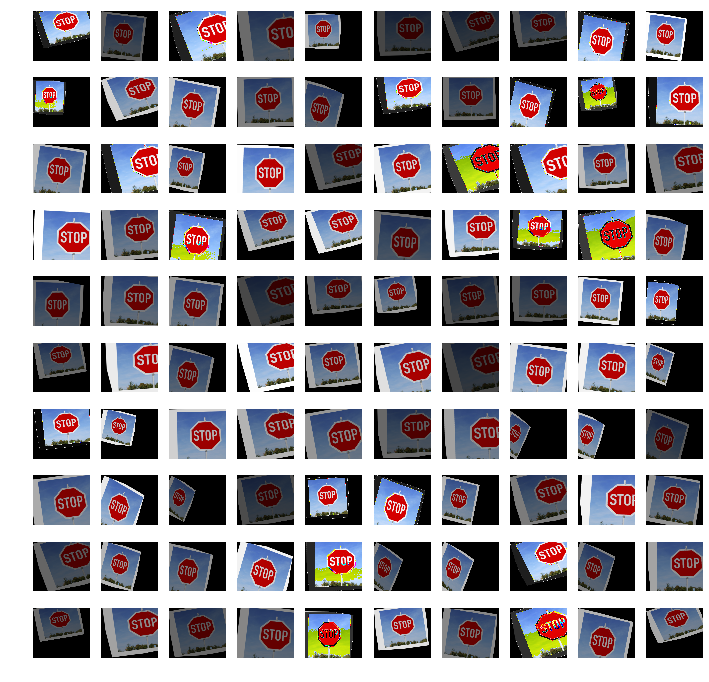

In [6]:
# Testing jittering function
image = mpimg.imread('stopsign.png')
plt.imshow(image);
plt.axis('off');

gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
plt.figure(figsize=(12,12))
for i in range(100):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(image,20,10,5,brightness=1)

    plt.subplot(10,10,i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [7]:
# Let's produce the augmented data and balance uthe datset with 1800 samples for each class
# in the training set

print('X, y shapes:', X_train.shape, y_train.shape)

input_indices = []
output_indices = []

for class_n in range(n_classes):
    print(class_n, ': ', end='')
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    if n_samples < 1800:
        for i in range(1800 - n_samples):
            input_indices.append(class_indices[0][i%n_samples])
            output_indices.append(X_train.shape[0])
            new_img = X_train[class_indices[0][i % n_samples]]
            new_img = transform_image(new_img,10,2,2,brightness=1)
            X_train = np.concatenate((X_train, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)
            if i % 50 == 0:
                print('|', end='')
            elif i % 10 == 0:
                print('-',end='')
    print('')
            
print('X, y shapes:', X_train.shape, y_train.shape)

X, y shapes: (34799, 32, 32, 3) (34799,)
0 : |----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|-
1 : 
2 : 
3 : |----|----|----|----|----|----|----|----|----|----|---
4 : |--
5 : |----|----|----
6 : |----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|---
7 : |----|----|----|----|----|----|----|----|----|----|
8 : |----|----|----|----|----|----|----|----|----|----|---
9 : |----|----|----|----|----|----|----|----|----|--
10 : 
11 : |----|----|----|----|----|----|----|----|----|----|----|----|--
12 : 
13 : 
14 : |----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
15 : |----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
16 : |----|----|----|----|----|----|----|-

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


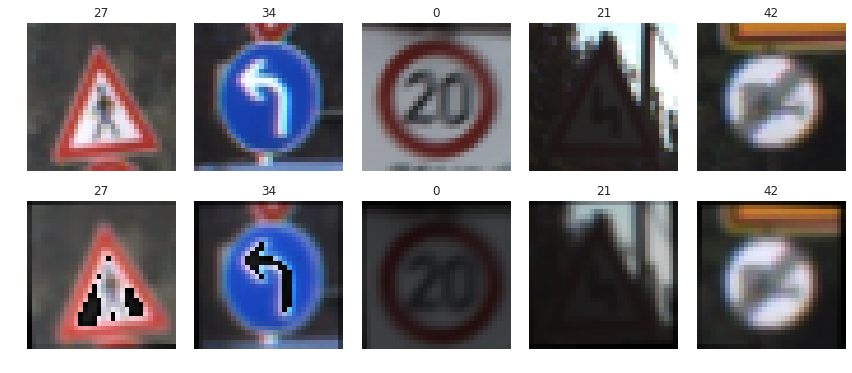

In [11]:
# show comparisons of 5 random augmented data points
choices = list(range(len(input_indices)))
picks = []
for i in range(5):
    rnd_index = np.random.randint(low=0,high=len(choices))
    picks.append(choices.pop(rnd_index))
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(5):
    image = X_train[input_indices[picks[i]]].squeeze()
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[input_indices[picks[i]]])
for i in range(5):
    image = X_train[output_indices[picks[i]]].squeeze()
    axs[i+5].axis('off')
    axs[i+5].imshow(image)
    axs[i+5].set_title(y_train[output_indices[picks[i]]])

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


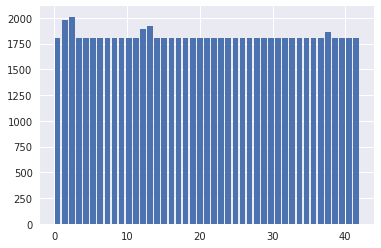

In [12]:
# New histogram of label frequency
n, bins, patches = plt.hist(y_train, bins=n_classes, rwidth=0.8)

In [13]:
# Record augmented data
aug_train = {'features': X_train,
             'labels': y_train}
aug_val = {'features': X_validation,
             'labels': y_validation}
aug_test = {'features': X_test,
             'labels': y_test}
pickle.dump(aug_train, open( "./my-augmented-data/aug_train.p", "wb" ) )
pickle.dump(aug_val, open( "./my-augmented-data/aug_val.p", "wb" ) )
pickle.dump(aug_test, open( "./my-augmented-data/aug_test.p", "wb" ) )

print('done')

done


In [14]:
# Checking the sequence/order of the images by id
print('Sequence of images by id:\n', y_train[0:300], '\n')

# Check mean and std of data
print('train: mean, std ', np.mean(X_train), np.std(X_train))
print('validation: mean, std ', np.mean(X_validation), np.std(X_validation))
print('test: mean, std ', np.mean(X_test), np.std(X_test))

Sequence of images by id:
 [41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31] 

train: mean, std  67.2015904066 60.1080150362
validation: 

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


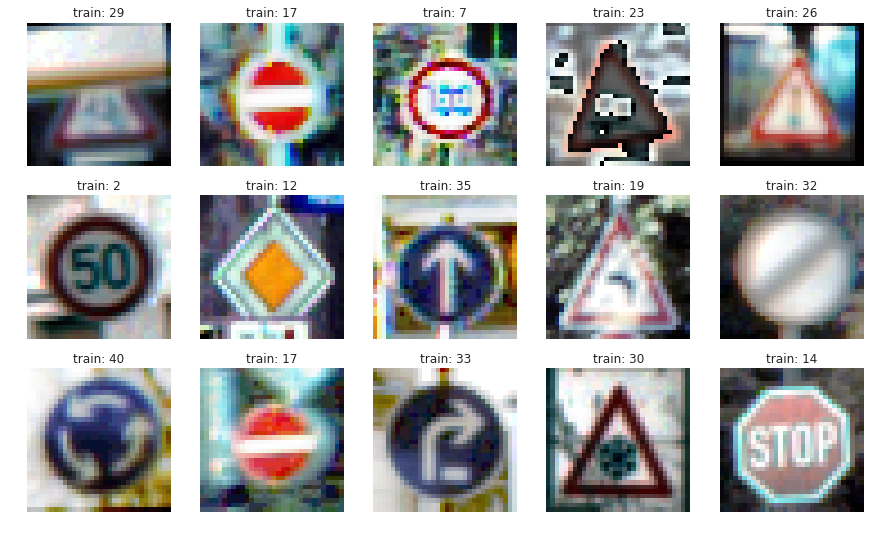

In [21]:
nrows = 3 # change it here the way you want, 0 will give error
ncols = 5 # change it here the way you want, 0 will give error
plotsignal(X_train, y_train, nrows, ncols, cmap=None, prefix_label = 'train:')

In [22]:
# Normalization

# Before normalize
print('Before Normalization:')
print(np.min(X_train), np.mean(X_train), np.max(X_train))
print(np.min(X_validation), np.mean(X_validation), np.max(X_validation))
print(np.min(X_test), np.mean(X_test), np.max(X_test))

# Normalizing on interval of [0,1]
X_train = X_train / 255.
X_validation = X_validation / 255.
X_test = X_test / 255.
print('[0,1] by 255:')
print(np.min(X_train), np.mean(X_train), np.max(X_train))
print(np.min(X_validation), np.mean(X_validation), np.max(X_validation))
print(np.min(X_test), np.mean(X_test), np.max(X_test))


Before Normalization:
0 129.803644766 255
0 131.772328072 255
0 131.973807016 255
[0,1] by 255:
0.0 0.509033901042 1.0
0.0 0.516754227733 1.0
0.0 0.517544341241 1.0


In [23]:
# Initial shuffle the training data
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

# Checking the sequence/order of the images by id
print('Sequence of images by id:\n', y_train[0:300], '\n')

Sequence of images by id:
 [ 3 37 38 14  9 29 40 30 39 25 40 32 11 32 17  5 37  6  2 20 34 30  7 26 14
 40 36 37 28 28 20  8 24 26 20 35 29 16  3  9 21  6 41 11 21 26 40 21  6 38
 20 10 18 29 29 38  6 36 41 34 27 23 12 39 20 37 14 33 33 22  5 35 17  5 35
 15 21  7 33 14 33 38 32 34 24  4  4 11 17 34 40 16 39 25 39 30 28 23 24 18
 12 33 37 25 32  9  4  1 35 17  9 34 31 39 16 16 41 15 38 36  9 17 31  2  6
 16 40  7 12 18 35  4  5  3 13  6 37 19 39 12 12  2 23 26 16 25 32 13 38 35
 40 21  6  5 20 10 35 13 40  5  2 10 26  3 34 40  7 28 33  1 10 39 13 23 28
  2 15 12 15  4 32 42 21 31 12 18 12 19  2  5 20  7 12 13 18 31 30  5 23  4
 40 13 30 22  2 40 41 25 21 40 21  3 18 36  4  0  2 11 30  6 22  8  7  7 20
 37  5 20  1 25 40 14 33 13 25 19 18 18 19 39 22 15 16  0 34 33 16 25  6 36
 20 17 36  2 31  0  7 29 34 21 34 36 38 31  0 18 26 24 36 30 28 27 16 31 31
 33 22  5  1 26 19 22 39  0  7 29 12  4 29 31 36 35  9  2 35 19 36 27 15 12] 



### Model Architecture

In [24]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# Convolution and max pooling helper function
def conv2d_maxpool(x_tensor, weights, biases, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :weights: weights
    :biases: biases
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """  
    
    # Convolution
    #print('x_tensor shape:', x_tensor.get_shape())
    x_tensor = tf.nn.conv2d(x_tensor,
                            weights,
                            strides=[1, conv_strides[0], conv_strides[1], 1],
                            padding='SAME')    
    #print('conv2d shape:', x_tensor.get_shape())
    
    # Add bias
    x_tensor = tf.nn.bias_add(x_tensor, biases)
    #print('add b shape:', x_tensor.get_shape())
    
    # Add nonlinear activation, ReLu
    x_tensor = tf.nn.relu(x_tensor)
    #print('relu shape:', x_tensor.get_shape())
    
    # Sampling with Max Pooling
    x_tensor = tf.nn.max_pool(x_tensor,
                              ksize=[1, pool_ksize[0], pool_ksize[1], 1],
                              strides=[1, pool_strides[0], pool_strides[1], 1],
                              padding='SAME')    
    #print('max pool shape:', x_tensor.get_shape())
    
    
    return x_tensor 

# Convolution helper function
def conv2d(x_tensor, weights, biases, conv_ksize, conv_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :weights: weights
    :biases: biases
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    : return: A tensor that represents convolution of x_tensor
    """  
    
    # Convolution
    #print('x_tensor shape:', x_tensor.get_shape())
    x_tensor = tf.nn.conv2d(x_tensor,
                            weights,
                            strides=[1, conv_strides[0], conv_strides[1], 1],
                            padding='SAME')    
    #print('conv2d shape:', x_tensor.get_shape())
    
    # Add bias
    x_tensor = tf.nn.bias_add(x_tensor, biases)
    #print('add b shape:', x_tensor.get_shape())
    
    # Add nonlinear activation, ReLu
    x_tensor = tf.nn.relu(x_tensor)
    #print('relu shape:', x_tensor.get_shape())
   
    
    return x_tensor 


In [25]:
# Network Parameters

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Depths
# 'ini' = Initial numbers of channels
# 'cx' = convolution depth output
out_node = 36
depth = {
    'ini': 3,
    'c1': out_node,
    'c2': 2*out_node,
    'c3': 2*out_node,
    'c4': 2*out_node,
    'c5': 2*out_node,
    'c6': 43
}

# Kernel sizes
ksize = {
    '1x1': [1,1],
    '3x3': [3,3]
}

# Stride sizes
strides = {
    '1x1': [1,1],
    '2x2': [2,2]
}


# Weights & Biases
# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
# mu = mean
# sigma = std deviation
mu = 0
sigma = 0.1
weights = {
    'wc0': tf.Variable(tf.truncated_normal(shape=(ksize['1x1'][0],ksize['1x1'][1],depth['ini'],depth['ini']), mean = mu, stddev = sigma), name='wc0'),
    'wc1': tf.Variable(tf.truncated_normal(shape=(ksize['3x3'][0],ksize['3x3'][1],depth['ini'],depth['c1']), mean = mu, stddev = sigma), name='wc1'),
    'wc1_max': tf.Variable(tf.truncated_normal(shape=(ksize['3x3'][0],ksize['3x3'][1],depth['c1'],depth['c1']), mean = mu, stddev = sigma), name='wc1_max'),
    'wc2': tf.Variable(tf.truncated_normal(shape=(ksize['3x3'][0],ksize['3x3'][1],depth['c1'],depth['c2']), mean = mu, stddev = sigma), name='wc2'),
    'wc2_max': tf.Variable(tf.truncated_normal(shape=(ksize['3x3'][0],ksize['3x3'][1],depth['c2'],depth['c2']), mean = mu, stddev = sigma), name='wc2_max'),
    'wc3': tf.Variable(tf.truncated_normal(shape=(ksize['3x3'][0],ksize['3x3'][1],depth['c2'],depth['c3']), mean = mu, stddev = sigma), name='wc3'),
    'wc4': tf.Variable(tf.truncated_normal(shape=(ksize['3x3'][0],ksize['3x3'][1],depth['c3'],depth['c4']), mean = mu, stddev = sigma), name='wc4'),
    'wc5': tf.Variable(tf.truncated_normal(shape=(ksize['1x1'][0],ksize['1x1'][1],depth['c4'],depth['c5']), mean = mu, stddev = sigma), name='wc5'),
    'wc6': tf.Variable(tf.truncated_normal(shape=(ksize['1x1'][0],ksize['1x1'][1],depth['c5'],depth['c6']), mean = mu, stddev = sigma), name='wc6')
}

biases = {
    'bc0': tf.Variable(tf.zeros(depth['ini']), name='bc0'),
    'bc1': tf.Variable(tf.zeros(depth['c1']), name='bc1'),
    'bc2': tf.Variable(tf.zeros(depth['c2']), name='bc2'),
    'bc3': tf.Variable(tf.zeros(depth['c3']), name='bc3'),
    'bc4': tf.Variable(tf.zeros(depth['c4']), name='bc4'),
    'bc5': tf.Variable(tf.zeros(depth['c5']), name='bc5'),
    'bc6': tf.Variable(tf.zeros(depth['c6']), name='bc6')
}



In [26]:
##############################
## Build the Neural Network ##
##############################

# Features
x = tf.placeholder(tf.float32, (None, 32, 32, depth['ini']))

# One hot encoded Labels
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# Exponential decay factor for learning rate
rate = tf.placeholder(tf.float32)

# L2 regularization parameter
beta = tf.placeholder(tf.float32)

# Dropout keep percentage parameter
keep_prob = tf.placeholder(tf.float32)


# Input 32x32x3
l0 = x
print('l0 shape:', l0.get_shape())

# Input 32x32x3. Output 32x32x3
l1 = conv2d(x_tensor=l0, weights=weights['wc0'], biases=biases['bc0'], conv_ksize=ksize['1x1'],
            conv_strides=strides['1x1'])

# Input 32x32x1. Output 16x16x36
l1 = conv2d(x_tensor=l1, weights=weights['wc1'], biases=biases['bc1'], conv_ksize=ksize['3x3'],
            conv_strides=[1,1])  
l1 = conv2d_maxpool(x_tensor=l1, weights=weights['wc1_max'], biases=biases['bc1'],
                    conv_ksize=ksize['3x3'], conv_strides=strides['1x1'], pool_ksize=ksize['3x3'],
                    pool_strides=strides['2x2'])
l1 = tf.nn.dropout(l1, keep_prob)
print('l1 shape:', l1.get_shape())

# Input 16x16x36. Output 8x8x72 
l2 = conv2d(x_tensor=l1, weights=weights['wc2'], biases=biases['bc2'], conv_ksize=ksize['3x3'],
            conv_strides=strides['1x1'])
l2 = conv2d_maxpool(x_tensor=l2, weights=weights['wc2_max'], biases=biases['bc2'],
                    conv_ksize=ksize['3x3'], conv_strides=strides['1x1'], pool_ksize=ksize['3x3'],
                    pool_strides=strides['2x2'])
l2 = tf.nn.dropout(l2, keep_prob)
print('l2 shape:', l2.get_shape())
#'''
# Input 8x8x72. Output 4x4x72
l3 = conv2d_maxpool(x_tensor=l2, weights=weights['wc3'], biases=biases['bc3'],
                    conv_ksize=ksize['3x3'], conv_strides=strides['1x1'], pool_ksize=ksize['3x3'],
                    pool_strides=strides['2x2'])
l3 = tf.nn.dropout(l3, keep_prob)
print('l3 shape:', l3.get_shape())
#'''
# Input 4x4x72. Output 4x4x72
l4 = conv2d(x_tensor=l3, weights=weights['wc4'], biases=biases['bc4'], conv_ksize=ksize['3x3'],
            conv_strides=strides['1x1'])
print('l4 shape:', l4.get_shape())

# Input 4x4x72. Output 4x4x72
l5 = conv2d(x_tensor=l4, weights=weights['wc5'], biases=biases['bc5'], conv_ksize=ksize['1x1'],
            conv_strides=strides['1x1'])
print('l5 shape:', l5.get_shape())

# Input 4x4x72. Output 4x4x43 
l6 = conv2d(x_tensor=l5, weights=weights['wc6'], biases=biases['bc6'], conv_ksize=ksize['1x1'],
            conv_strides=strides['1x1'])
print('l6 shape:', l6.get_shape())

# Input 4x4x43. Output 1x1x43     
l6 = tf.nn.avg_pool(l6, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME') 
print('l6 avg shape:', l6.get_shape())

# Input 1x1x43. Output 1x43 
logits = flatten(l6)
print('logits shape:', logits.get_shape())



l0 shape: (?, 32, 32, 3)
l1 shape: (?, 16, 16, 36)
l2 shape: (?, 8, 8, 72)
l3 shape: (?, 4, 4, 72)
l4 shape: (?, 4, 4, 72)
l5 shape: (?, 4, 4, 72)
l6 shape: (?, 4, 4, 43)
l6 avg shape: (?, 1, 1, 43)
logits shape: (?, 43)


### Train, Validate and Test the Model

A validation set is used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [27]:
# Loss
# L2 regularization and Rate of learning rate decay implementation reference:
# https://medium.com/@muddassirahmed/german-traffic-sign-classification-using-deep-learning-219c53fba329#.gjbzs4acj
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss = tf.reduce_mean(cross_entropy)
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(weights['wc1']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(weights['wc2']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(weights['wc3']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(weights['wc4']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(weights['wc5']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(weights['wc6']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(biases['bc1']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(biases['bc2']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(biases['bc3']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(biases['bc4']))
loss = tf.reduce_mean(loss+beta*tf.nn.l2_loss(biases['bc5']))
loss_operation = tf.reduce_mean(loss+beta*tf.nn.l2_loss(biases['bc6']))

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


In [28]:
# Evaluation of training
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples
#'''

In [43]:
# Try to overfit small sample of dataset to evaluate efficiency of cnn
# CS231n Winter 2016: Lecture 5: Neural Networks Part 2
# https://www.youtube.com/watch?v=gYpoJMlgyXA&index=10&list=PLFznuEIsFrh7j2ARuJzbDRb5iZip3rlNR&t=2059s
# Implementation reference:
# https://medium.com/@muddassirahmed/german-traffic-sign-classification-using-deep-learning-219c53fba329#.gjbzs4acj

import math


# Initial learning rate
lr = 0.0009

# L2 regularization (Beta)
b = 0.0001

# Rate of learning rate decay
k = 1e-5

# Try small subset of 20 images    
small_sample_x = X_train[0:20]
small_sample_y = y_train[0:20]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(small_sample_x)
    
    batch_size = 10
    print("Can we overfit it?.......")
    print()
    
    print("Decay: "+str(k))
    for i in range(100):
        
        lr = float(lr*np.exp(-k*i))
        
        for offset in range(0,num_examples,batch_size):
            end = offset + batch_size
            batch_x, batch_y = small_sample_x[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x:small_sample_x, y:small_sample_y, keep_prob: 0.5, rate:lr, beta:b})
            
        c = sess.run(loss_operation, feed_dict={x: small_sample_x, y: small_sample_y, keep_prob: 1., rate:lr, beta:b})
        print("Epoch: "+str(i)+" loss: "+str(c)+" learn rate:"+str(lr)+" beta: "+str(b)+" decay: "+str(k))

Can we overfit it?.......

Decay: 1e-05
Epoch: 0 loss: 3.80666 learn rate:0.0009 beta: 0.0001 decay: 1e-05
Epoch: 1 loss: 3.79813 learn rate:0.0008999910000449999 beta: 0.0001 decay: 1e-05
Epoch: 2 loss: 3.77429 learn rate:0.000899973000404996 beta: 0.0001 decay: 1e-05
Epoch: 3 loss: 3.71152 learn rate:0.0008999460016199677 beta: 0.0001 decay: 1e-05
Epoch: 4 loss: 3.60608 learn rate:0.0008999100044998501 beta: 0.0001 decay: 1e-05
Epoch: 5 loss: 3.55959 learn rate:0.0008998650101244938 beta: 0.0001 decay: 1e-05
Epoch: 6 loss: 3.52136 learn rate:0.000899811019843611 beta: 0.0001 decay: 1e-05
Epoch: 7 loss: 3.43292 learn rate:0.0008997480352767075 beta: 0.0001 decay: 1e-05
Epoch: 8 loss: 3.32448 learn rate:0.0008996760583130023 beta: 0.0001 decay: 1e-05
Epoch: 9 loss: 3.30584 learn rate:0.0008995950911113329 beta: 0.0001 decay: 1e-05
Epoch: 10 loss: 3.33381 learn rate:0.0008995051361000472 beta: 0.0001 decay: 1e-05
Epoch: 11 loss: 3.33657 learn rate:0.0008994061959768828 beta: 0.0001 deca

In [45]:
# Training the model

EPOCHS = 60
BATCH_SIZE = 512
save_file = 'train_model2.ckpt'

# Initial learning rate
lr = 0.0009

# L2 regularization (Beta)
b = 0.0001

# Rate of learning rate decay
k = 1e-5

log = {'train_accuracy':[], 'val_accuracy':[]}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print('lr:', lr)
    for i in range(EPOCHS):
        lr = float(lr*np.exp(-k*i))
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5, rate:lr, beta:b})
            
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}, Train Accuracy = {:.3f}".format(validation_accuracy, train_accuracy))
        print()
        
        log['train_accuracy'].append(train_accuracy)
        log['val_accuracy'].append(validation_accuracy)
        
    saver.save(sess, save_file)
    print("Model saved")


Training...
lr: 0.0009
EPOCH 1 ...
Validation Accuracy = 0.083, Train Accuracy = 0.103

EPOCH 2 ...
Validation Accuracy = 0.237, Train Accuracy = 0.260

EPOCH 3 ...
Validation Accuracy = 0.317, Train Accuracy = 0.376

EPOCH 4 ...
Validation Accuracy = 0.416, Train Accuracy = 0.483

EPOCH 5 ...
Validation Accuracy = 0.542, Train Accuracy = 0.598

EPOCH 6 ...
Validation Accuracy = 0.627, Train Accuracy = 0.680

EPOCH 7 ...
Validation Accuracy = 0.705, Train Accuracy = 0.782

EPOCH 8 ...
Validation Accuracy = 0.760, Train Accuracy = 0.829

EPOCH 9 ...
Validation Accuracy = 0.809, Train Accuracy = 0.869

EPOCH 10 ...
Validation Accuracy = 0.819, Train Accuracy = 0.894

EPOCH 11 ...
Validation Accuracy = 0.867, Train Accuracy = 0.926

EPOCH 12 ...
Validation Accuracy = 0.877, Train Accuracy = 0.940

EPOCH 13 ...
Validation Accuracy = 0.911, Train Accuracy = 0.952

EPOCH 14 ...
Validation Accuracy = 0.927, Train Accuracy = 0.965

EPOCH 15 ...
Validation Accuracy = 0.931, Train Accuracy = 0.9

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


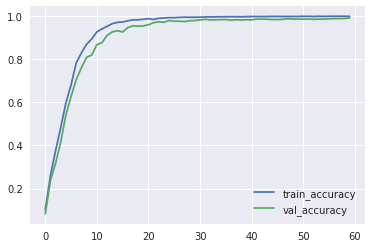

In [46]:
# Visualize log
plt.plot(log['train_accuracy'], label='train_accuracy')
plt.plot(log['val_accuracy'], label='val_accuracy')
plt.legend()

In [65]:
# Additionalt training

EPOCHS = 20
BATCH_SIZE = 512
save_file = 'train_model2b.ckpt'
new_saver = tf.train.Saver()

# Initial learning rate
lr = 0.0005 # decreased learning rate

# L2 regularization (Beta)
b = 0.0001

# Rate of learning rate decay
k = 1e-5

with tf.Session() as sess:
    new_saver.restore(sess, tf.train.latest_checkpoint('.'))
    num_examples = len(X_train)
    
    print("Additional Training...")
    print('lr:', lr)
    for i in range(EPOCHS):
        lr = float(lr*np.exp(-k*i))
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5, rate:lr, beta:b})
            
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}, Train Accuracy = {:.3f}".format(validation_accuracy, train_accuracy))
        print()
        
        log['train_accuracy'].append(train_accuracy)
        log['val_accuracy'].append(validation_accuracy)
        
    new_saver.save(sess, save_file)
    print("Model saved")

Additional Training...
lr: 0.0005
EPOCH 1 ...
Validation Accuracy = 0.989, Train Accuracy = 0.999

EPOCH 2 ...
Validation Accuracy = 0.989, Train Accuracy = 0.999

EPOCH 3 ...
Validation Accuracy = 0.987, Train Accuracy = 0.999

EPOCH 4 ...
Validation Accuracy = 0.989, Train Accuracy = 0.999

EPOCH 5 ...
Validation Accuracy = 0.992, Train Accuracy = 0.999

EPOCH 6 ...
Validation Accuracy = 0.989, Train Accuracy = 0.999

EPOCH 7 ...
Validation Accuracy = 0.991, Train Accuracy = 0.999

EPOCH 8 ...
Validation Accuracy = 0.990, Train Accuracy = 0.999

EPOCH 9 ...
Validation Accuracy = 0.989, Train Accuracy = 1.000

EPOCH 10 ...
Validation Accuracy = 0.990, Train Accuracy = 0.999

EPOCH 11 ...
Validation Accuracy = 0.990, Train Accuracy = 0.999

EPOCH 12 ...
Validation Accuracy = 0.990, Train Accuracy = 0.999

EPOCH 13 ...
Validation Accuracy = 0.988, Train Accuracy = 1.000

EPOCH 14 ...
Validation Accuracy = 0.990, Train Accuracy = 0.999

EPOCH 15 ...
Validation Accuracy = 0.988, Train Acc

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


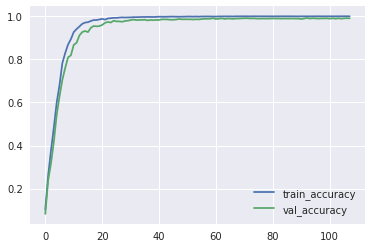

In [66]:
# Visualize log
plt.plot(log['train_accuracy'], label='train_accuracy')
plt.plot(log['val_accuracy'], label='val_accuracy')
plt.legend()

In [67]:
# Helpers functions to visualize cnn
# https://medium.com/@awjuliani/visualizing-neural-network-layer-activation-tensorflow-tutorial-d45f8bf7bbc4#.t37fmyoee
def getActivations(layer,stimuli):
    sess = tf.get_default_session()
    units = sess.run(layer,feed_dict={x:stimuli ,keep_prob:1.0})
    plotNNFilter(units)

def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.axis('off')
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")



(-0.5, 31.5, 31.5, -0.5)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


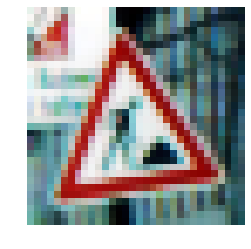

In [70]:
# Initial image
imageToUse = X_train[546]
plt.imshow(imageToUse.squeeze())
plt.axis('off')

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


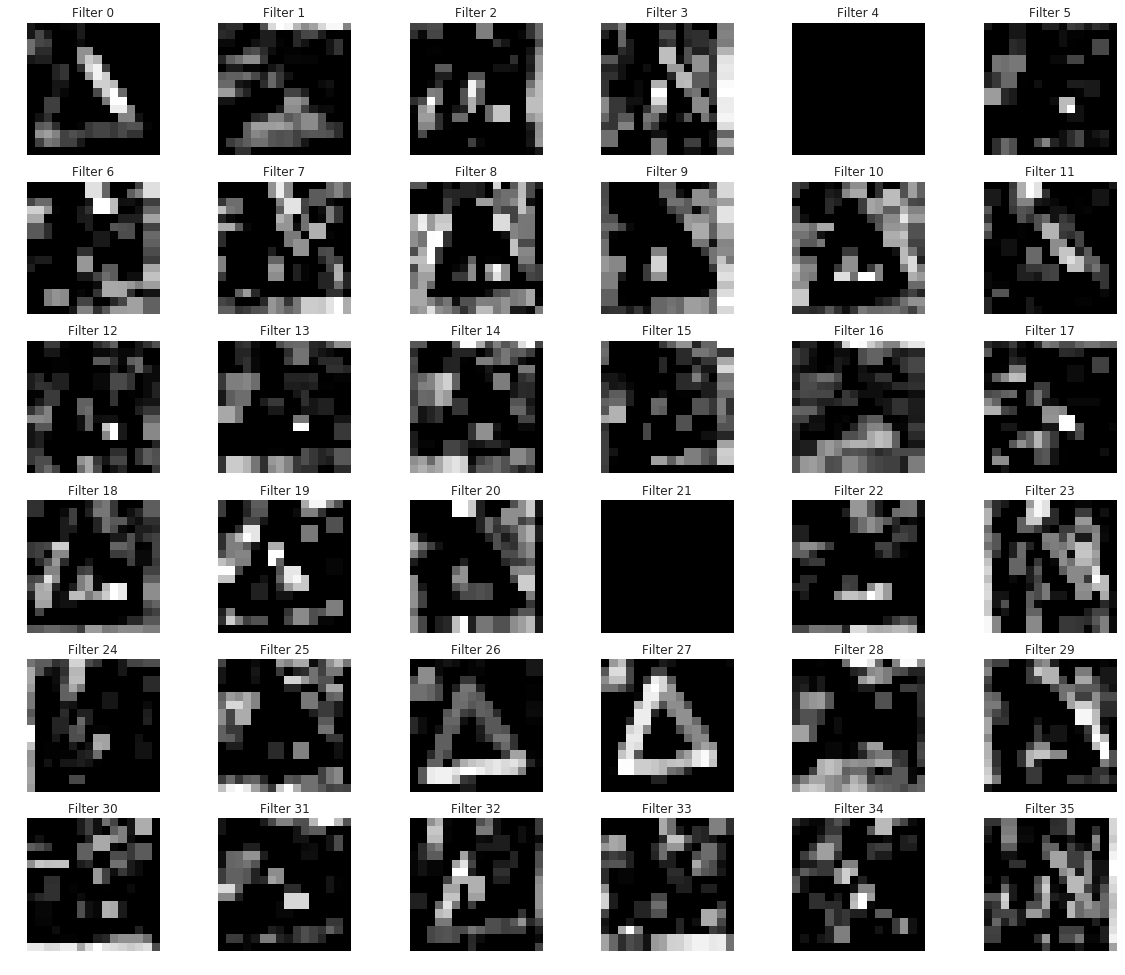

In [71]:
#### Plot l1 layer:
# l0, l1, l2, l3, l4, l5, l6, logits
new_saver = tf.train.Saver()
with tf.Session() as sess:
    new_saver.restore(sess, tf.train.latest_checkpoint('.'))
    getActivations(l1, imageToUse[np.newaxis,:,:,:])

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


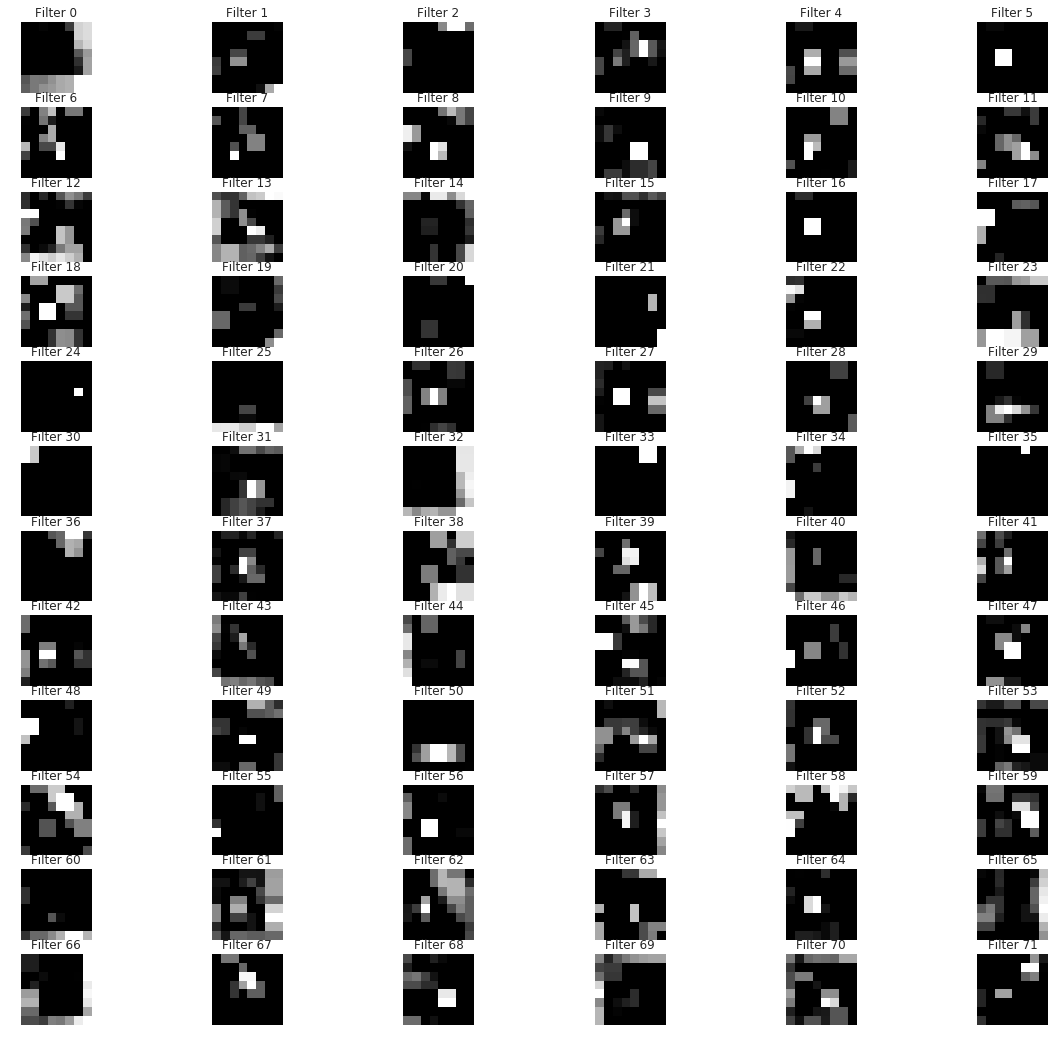

In [72]:
#### Plot l2 layer:
# l0, l1, l2, l3, l4, l5, l6, logits
new_saver = tf.train.Saver()
with tf.Session() as sess:
    new_saver.restore(sess, tf.train.latest_checkpoint('.'))
    getActivations(l2, imageToUse[np.newaxis,:,:,:])

In [73]:
# Evaluation of test
predictions = tf.argmax(logits, 1)
actual = tf.argmax(one_hot_y,1)
correct_pred = tf.equal(predictions, actual)
accuracy_oper = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
new_saver = tf.train.Saver()

# Implementation reference:
# https://medium.com/@muddassirahmed/german-traffic-sign-classification-using-deep-learning-219c53fba329#.gjbzs4acj
def evaluate_on_test_data(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()

    # List of indexes and prediction of images gotten wrong by the network
    gotten_wrong_list = []    
    gotten_wrong_index = 0
    
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_oper, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        pred = sess.run(predictions, feed_dict={x:batch_x, y:batch_y, keep_prob: 1.})
        act = sess.run(actual, feed_dict={y:batch_y})
        
        for a,b in zip(pred,act):
            if(not a == b):
                gotten_wrong_list.append((gotten_wrong_index,a))
            gotten_wrong_index = gotten_wrong_index+1
        total_accuracy += (accuracy * len(batch_x))
    return (total_accuracy / num_examples), gotten_wrong_list, pred, act

In [74]:
# Evaluate the final model
with tf.Session() as sess:
    new_saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy, gotten_wrong_list, pred, act = evaluate_on_test_data(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.980


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


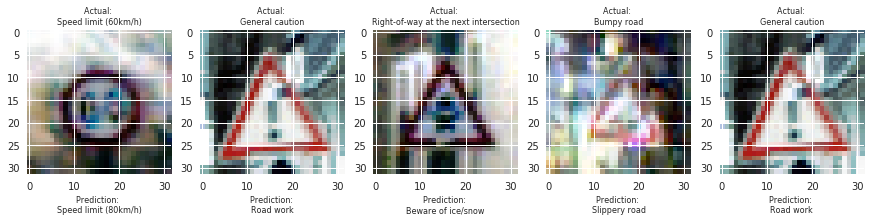

In [75]:
# Implementation reference:
# https://medium.com/@muddassirahmed/german-traffic-sign-classification-using-deep-learning-219c53fba329#.gjbzs4acj


# Load sign names to further evaluate the performance of my network
import csv

sign_names = []
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        sign_names.append(row[1])
    sign_names.reverse()
    sign_names.pop()
    sign_names.reverse()
    
# Plot 5 wrong guess from my model
import matplotlib.patches as patches
import random

num_x = 5
num_y = 1
fig, axarr = plt.subplots(num_y,num_x)
fig.set_size_inches(15,15)
for i in range(num_x*num_y):
    n = random.random()*len(gotten_wrong_list)
    
    image = X_test[gotten_wrong_list[int(n)][0]]
    axarr[i].imshow(image.squeeze())
    
    axarr[i].set_title("Actual: \n"+sign_names[y_test[gotten_wrong_list[int(n)][0]]],fontsize=8)
    axarr[i].set_xlabel("Prediction: \n"+sign_names[gotten_wrong_list[int(n)][1]],fontsize=8)

---

## Step 3: Test a Model on New Images

To get a better insight into how the model is working, I have downloaded six pictures of German traffic signs from the web and used it to predict the traffic sign type.

I am using `signnames.csv`, it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

New Image shape (6, 32, 32, 4)


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


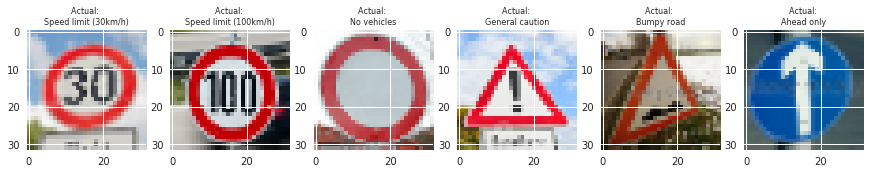

In [82]:
# Load images
from matplotlib.image import imread

new_images_list = [1,7,15,18,22,35]
new_images = []

for i in new_images_list:
    new_images.append(imread("./my_images/"+str(i)+".png",))
new_images = np.array(new_images)
print('New Image shape', new_images.shape)

# Check images 
num_x = 6
num_y = 1
fig, axarr = plt.subplots(num_y,num_x)
fig.set_size_inches(15,15)
for i in range(num_x*num_y):
   
    image = new_images[i]
    axarr[i].imshow(image.squeeze())
    axarr[i].set_title("Actual: \n"+sign_names[new_images_list[i]],fontsize=8)   

### Predict the Sign Type for Each Image

New Images RGB shape: (6, 32, 32, 4)
New Images 3 channels shape: (6, 32, 32, 3)


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


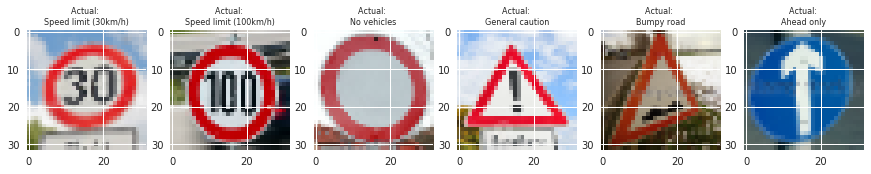

In [88]:
# get rid of alpha channels from my custom images from internet  
import cv2

def _4_to_3channel(images):
    """
    Convert 4 channel to 3 channels.
    images = 4D array containing raw pixel data of the images, (num examples, width, height, channels)    
    """
    # Initialize 4D outputs
    img = np.zeros([len(images),images[0].shape[0], images[0].shape[1], 3]) # to return 3 channels

    # Loop on each image
    for i in range(len(images)):
        img[i] = cv2.cvtColor(images[i], cv2.COLOR_BGRA2BGR)    
    
    return img
    
# Convert images
new_images_rgb = new_images.copy()
new_images_3ch = _4_to_3channel(new_images_rgb)

# Check shapes
print('New Images RGB shape:', new_images_rgb.shape)
print('New Images 3 channels shape:', new_images_3ch.shape)

# Check images
num_x = 6
num_y = 1
fig, axarr = plt.subplots(num_y,num_x)
fig.set_size_inches(15,15)
for i in range(num_x*num_y):
   
    image = new_images_3ch[i].squeeze()
    axarr[i].imshow(image, cmap='gray')
    axarr[i].set_title("Actual: \n"+sign_names[new_images_list[i]],fontsize=8)

In [90]:
# Evaluate custom images accuracy
with tf.Session() as sess:
    new_saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy, gotten_wrong_list, pred, act = evaluate_on_test_data(new_images_3ch, np.array(new_images_list))
    print("Prediction: ", pred)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Prediction:  [ 1  7 15 18 22 35]
Test Accuracy = 1.000


### Analyze Performance

Test Accuracy = 1.000


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


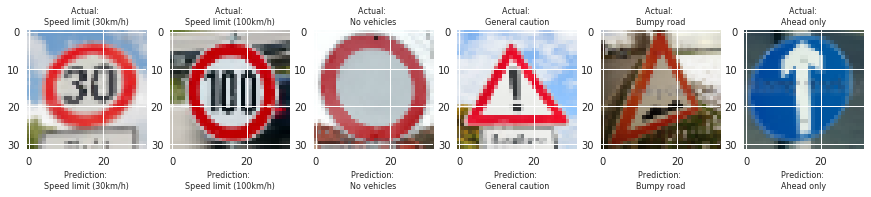

In [91]:
# Plot the images along with their predictions
import matplotlib.patches as patches
import random

print("Test Accuracy = {:.3f}".format(test_accuracy))
num_x = 6
num_y = 1
fig, axarr = plt.subplots(num_y,num_x)
fig.set_size_inches(15,15)
for i in range(num_x*num_y):
    axarr[i].imshow(new_images[i].squeeze())    

    axarr[i].set_title("Actual: \n"+sign_names[act[int(i)]],fontsize=8)
    axarr[i].set_xlabel("Prediction: \n"+sign_names[pred[int(i)]],fontsize=8)

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, let's print out the model's softmax probabilities to show the **certainty** of the model's predictions.


In [93]:
# Get logits
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess = tf.get_default_session()
    log = sess.run(logits, feed_dict={x:new_images_3ch, y:np.array(new_images_list), keep_prob: 1.})
    #print(log)
    top = sess.run(tf.nn.top_k(tf.constant(log), k=5))
    print(top)


TopKV2(values=array([[ 19.01696205,  14.76329803,  12.94693565,  12.29158878,
         12.11443424],
       [ 25.85175514,  19.61034775,  19.2266922 ,  16.75712967,
         15.99718094],
       [ 33.74851608,  17.19134331,  13.92902851,  12.12103653,
         11.72377205],
       [ 40.41031265,  22.74430847,  21.59794617,  19.8938446 ,
         17.68827057],
       [ 27.42382622,  15.44161129,  14.70912075,  13.91739845,
         11.51003265],
       [ 35.49059677,  24.44086075,  23.55379295,  18.30643845,
         16.09711075]], dtype=float32), indices=array([[ 1, 14,  4,  5,  7],
       [ 7,  1,  8,  4,  5],
       [15, 13,  8, 35, 14],
       [18, 26, 24, 25, 31],
       [22, 26, 29, 25, 12],
       [35, 33, 36, 11, 37]], dtype=int32))


Input image class: 1 which is: Speed limit (30km/h)
Class: 1 is Speed limit (30km/h)
Class: 14 is Stop
Class: 4 is Speed limit (70km/h)
Class: 5 is Speed limit (80km/h)
Class: 7 is Speed limit (100km/h)


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


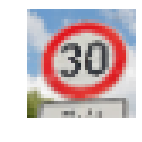

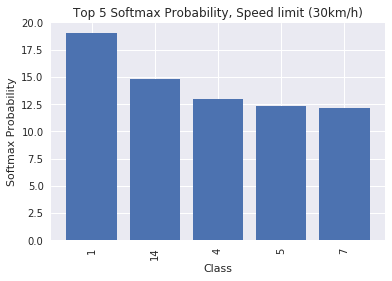

In [94]:
import pandas as pd        

i = 0 # choose 0 to 5 to go through each of the 6 custom images

print('Input image class:', new_images_list[i], 'which is:', sign_names[new_images_list[i]])
fig1, ax1 = plt.subplots( figsize=(2,2))
ax1.imshow(new_images[i].squeeze(), cmap="gray")
ax1.axis('off')

print('Class:', top[1][i][0], 'is', sign_names[top[1][i][0]])
print('Class:', top[1][i][1], 'is', sign_names[top[1][i][1]])
print('Class:', top[1][i][2], 'is', sign_names[top[1][i][2]])
print('Class:', top[1][i][3], 'is', sign_names[top[1][i][3]])
print('Class:', top[1][i][4], 'is', sign_names[top[1][i][4]])


df = pd.DataFrame(top[0][i], index = top[1][i])
ax2 = df.plot(kind='bar', legend = False, width = .8, title='Top 5 Softmax Probability, ' + sign_names[new_images_list[0]])
ax2.set_xlabel("Class")
ax2.set_ylabel("Softmax Probability")


Input image class: 7 which is: Speed limit (100km/h)
Class: 7 is Speed limit (100km/h)
Class: 1 is Speed limit (30km/h)
Class: 8 is Speed limit (120km/h)
Class: 4 is Speed limit (70km/h)
Class: 5 is Speed limit (80km/h)


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


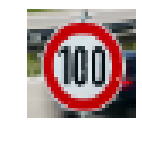

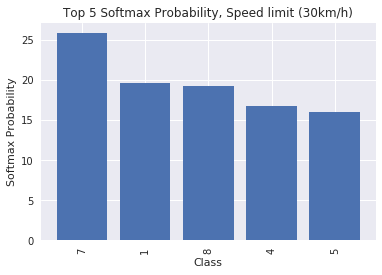

In [95]:
import pandas as pd        

i = 1 # choose 0 to 5 to go through each of the 6 custom images

print('Input image class:', new_images_list[i], 'which is:', sign_names[new_images_list[i]])
fig1, ax1 = plt.subplots( figsize=(2,2))
ax1.imshow(new_images[i].squeeze(), cmap="gray")
ax1.axis('off')

print('Class:', top[1][i][0], 'is', sign_names[top[1][i][0]])
print('Class:', top[1][i][1], 'is', sign_names[top[1][i][1]])
print('Class:', top[1][i][2], 'is', sign_names[top[1][i][2]])
print('Class:', top[1][i][3], 'is', sign_names[top[1][i][3]])
print('Class:', top[1][i][4], 'is', sign_names[top[1][i][4]])


df = pd.DataFrame(top[0][i], index = top[1][i])
ax2 = df.plot(kind='bar', legend = False, width = .8, title='Top 5 Softmax Probability, ' + sign_names[new_images_list[0]])
ax2.set_xlabel("Class")
ax2.set_ylabel("Softmax Probability")

Input image class: 15 which is: No vehicles
Class: 15 is No vehicles
Class: 13 is Yield
Class: 8 is Speed limit (120km/h)
Class: 35 is Ahead only
Class: 14 is Stop


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


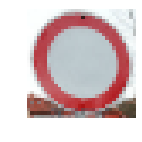

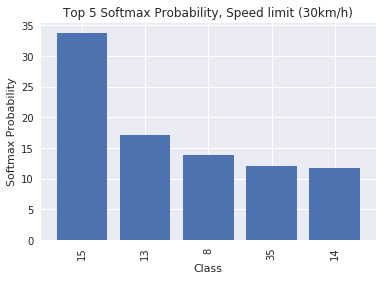

In [96]:
import pandas as pd        

i = 2 # choose 0 to 5 to go through each of the 6 custom images

print('Input image class:', new_images_list[i], 'which is:', sign_names[new_images_list[i]])
fig1, ax1 = plt.subplots( figsize=(2,2))
ax1.imshow(new_images[i].squeeze(), cmap="gray")
ax1.axis('off')

print('Class:', top[1][i][0], 'is', sign_names[top[1][i][0]])
print('Class:', top[1][i][1], 'is', sign_names[top[1][i][1]])
print('Class:', top[1][i][2], 'is', sign_names[top[1][i][2]])
print('Class:', top[1][i][3], 'is', sign_names[top[1][i][3]])
print('Class:', top[1][i][4], 'is', sign_names[top[1][i][4]])


df = pd.DataFrame(top[0][i], index = top[1][i])
ax2 = df.plot(kind='bar', legend = False, width = .8, title='Top 5 Softmax Probability, ' + sign_names[new_images_list[0]])
ax2.set_xlabel("Class")
ax2.set_ylabel("Softmax Probability")

Input image class: 18 which is: General caution
Class: 18 is General caution
Class: 26 is Traffic signals
Class: 24 is Road narrows on the right
Class: 25 is Road work
Class: 31 is Wild animals crossing


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


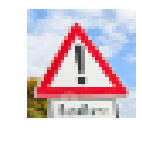

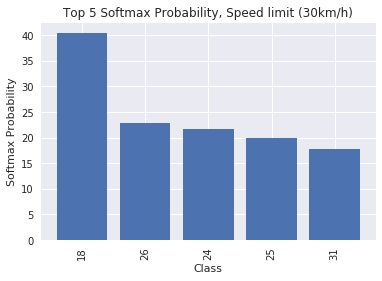

In [97]:
import pandas as pd        

i = 3 # choose 0 to 5 to go through each of the 6 custom images

print('Input image class:', new_images_list[i], 'which is:', sign_names[new_images_list[i]])
fig1, ax1 = plt.subplots( figsize=(2,2))
ax1.imshow(new_images[i].squeeze(), cmap="gray")
ax1.axis('off')

print('Class:', top[1][i][0], 'is', sign_names[top[1][i][0]])
print('Class:', top[1][i][1], 'is', sign_names[top[1][i][1]])
print('Class:', top[1][i][2], 'is', sign_names[top[1][i][2]])
print('Class:', top[1][i][3], 'is', sign_names[top[1][i][3]])
print('Class:', top[1][i][4], 'is', sign_names[top[1][i][4]])


df = pd.DataFrame(top[0][i], index = top[1][i])
ax2 = df.plot(kind='bar', legend = False, width = .8, title='Top 5 Softmax Probability, ' + sign_names[new_images_list[0]])
ax2.set_xlabel("Class")
ax2.set_ylabel("Softmax Probability")

Input image class: 22 which is: Bumpy road
Class: 22 is Bumpy road
Class: 26 is Traffic signals
Class: 29 is Bicycles crossing
Class: 25 is Road work
Class: 12 is Priority road


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


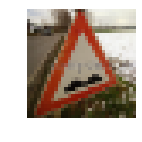

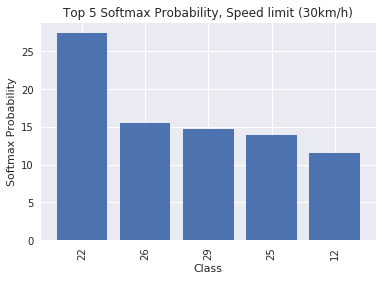

In [98]:
import pandas as pd        

i = 4 # choose 0 to 5 to go through each of the 6 custom images

print('Input image class:', new_images_list[i], 'which is:', sign_names[new_images_list[i]])
fig1, ax1 = plt.subplots( figsize=(2,2))
ax1.imshow(new_images[i].squeeze(), cmap="gray")
ax1.axis('off')

print('Class:', top[1][i][0], 'is', sign_names[top[1][i][0]])
print('Class:', top[1][i][1], 'is', sign_names[top[1][i][1]])
print('Class:', top[1][i][2], 'is', sign_names[top[1][i][2]])
print('Class:', top[1][i][3], 'is', sign_names[top[1][i][3]])
print('Class:', top[1][i][4], 'is', sign_names[top[1][i][4]])


df = pd.DataFrame(top[0][i], index = top[1][i])
ax2 = df.plot(kind='bar', legend = False, width = .8, title='Top 5 Softmax Probability, ' + sign_names[new_images_list[0]])
ax2.set_xlabel("Class")
ax2.set_ylabel("Softmax Probability")

Input image class: 35 which is: Ahead only
Class: 35 is Ahead only
Class: 33 is Turn right ahead
Class: 36 is Go straight or right
Class: 11 is Right-of-way at the next intersection
Class: 37 is Go straight or left


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


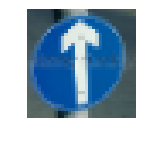

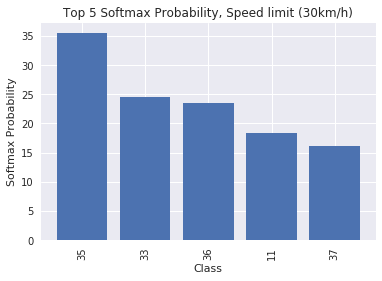

In [99]:
import pandas as pd        

i = 5 # choose 0 to 5 to go through each of the 6 custom images

print('Input image class:', new_images_list[i], 'which is:', sign_names[new_images_list[i]])
fig1, ax1 = plt.subplots( figsize=(2,2))
ax1.imshow(new_images[i].squeeze(), cmap="gray")
ax1.axis('off')

print('Class:', top[1][i][0], 'is', sign_names[top[1][i][0]])
print('Class:', top[1][i][1], 'is', sign_names[top[1][i][1]])
print('Class:', top[1][i][2], 'is', sign_names[top[1][i][2]])
print('Class:', top[1][i][3], 'is', sign_names[top[1][i][3]])
print('Class:', top[1][i][4], 'is', sign_names[top[1][i][4]])


df = pd.DataFrame(top[0][i], index = top[1][i])
ax2 = df.plot(kind='bar', legend = False, width = .8, title='Top 5 Softmax Probability, ' + sign_names[new_images_list[0]])
ax2.set_xlabel("Class")
ax2.set_ylabel("Softmax Probability")